In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import sys
sys.path.append('..')

import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np

import tensorflow as tf
from tensorflow.keras.models import load_model

from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

from src.data_loader import data_loader, preprocess_test_image
# from src.networks import pix2pix_generator

In [3]:
# generator = pix2pix_generator()
# generator.load_weights("../saved_models/pix2pix/pix2pix.keras")
generator = load_model('../saved_models/pix2pix/pix2pix.keras')

In [4]:
_, test_ds = data_loader()

In [5]:
def show_images(model, inp, tar=None):
    
    p = model.predict(inp)

    plt.figure(figsize=(6, 3))

    if tar is None:
        display_list = [inp[0], p[0]]
        title = ['Real Face', 'Predicted Face']
    else:
        display_list = [inp[0], tar[0], p[0]]
        title = ['Real Face', 'Comic Face', 'Predicted Face']

    for i in range(len(title)):
        plt.subplot(1, len(title), i+1)
        plt.title(title[i])
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

1/1 [==============================] - 3s 3s/step


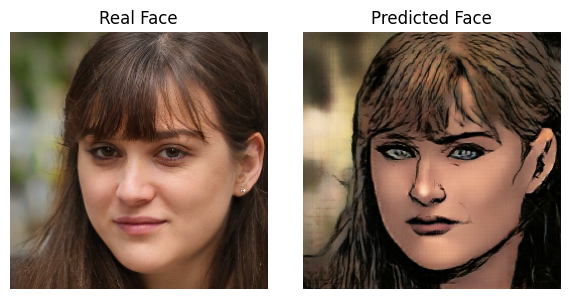

In [6]:
inp = preprocess_test_image("../data/face/5.jpg")
inp = tf.expand_dims(inp, axis=0)

show_images(generator, inp)

1/1 [==============================] - 5s 5s/step


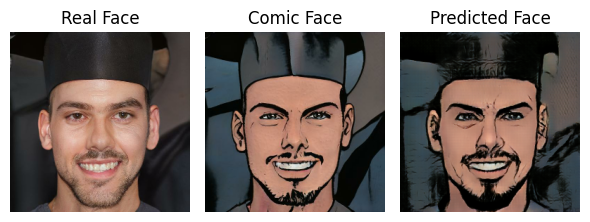

1/1 [==============================] - 0s 41ms/step


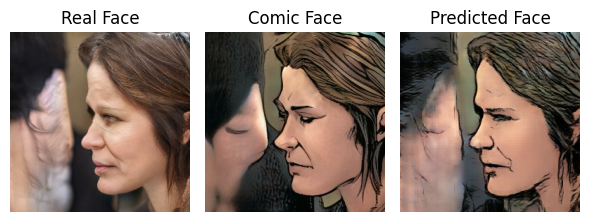

1/1 [==============================] - 0s 40ms/step


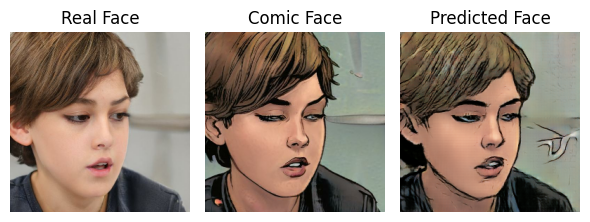

1/1 [==============================] - 0s 40ms/step


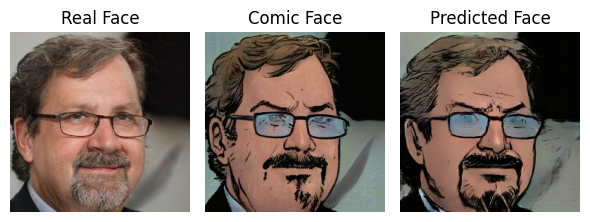

1/1 [==============================] - 0s 39ms/step


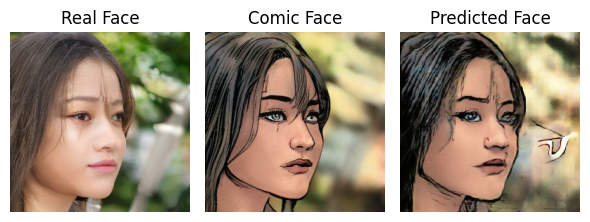

In [6]:
for inp, tar in test_ds.take(5):
    show_images(generator, inp, tar)

In [6]:
import tensorflow_gan as tfgan

In [7]:
@tf.function
def get_fid_score(real_image, gen_image):
    # size = tfgan.eval.INCEPTION_DEFAULT_IMAGE_SIZE

    num_inception_images = 1
    num_batches = 32 // num_inception_images
    fid = tfgan.eval.frechet_inception_distance(real_image, gen_image, num_batches=num_batches)
    return fid

In [8]:
losses = []
pbar = tqdm(total=31)
for inp, tar in test_ds.take(31):
    pred = generator.predict(inp, verbose=0)
    losses.append(get_fid_score(tar, pred))
    pbar.update()

  0%|          | 0/31 [00:00<?, ?it/s]

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.map_fn(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.map_fn(fn, elems))


In [9]:
losses = [x.numpy() for x in losses]
print(losses)

[86.20959, 99.56041, 100.96892, 96.94177, 109.86154, 102.779625, 104.87311, 101.80035, 95.85459, 118.802, 89.702644, 80.2831, 86.65843, 94.68424, 103.85378, 101.79922, 99.65943, 90.33347, 80.34632, 91.92738, 99.00669, 98.679695, 103.00515, 106.18827, 89.47793, 95.77184, 91.02524, 107.8488, 102.949646, 118.745155, 82.71841]


In [10]:
np.mean(losses)

97.81667

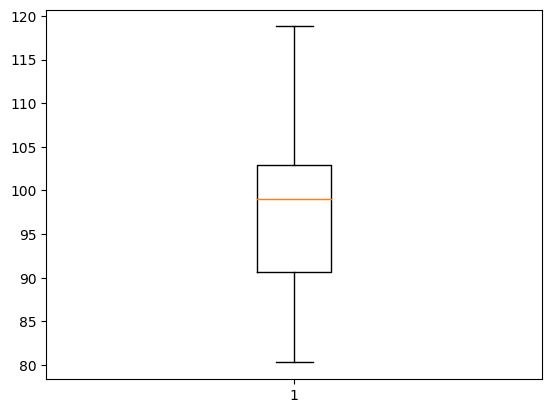

In [11]:
plt.boxplot(losses)
plt.show()

In [12]:
import pickle

with open("../saved_models/pix2pix/pix2pix_losses.p", "wb") as f:
    pickle.dump(losses, f)